In [ ]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 7.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

--2022-02-22 01:06:09--  https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76805 (75K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘us_macro_quarterly.xlsx’

us_macro_quarterly. 100%[===================>]  75.00K  --.-KB/s    in 0.03s   

2022-02-22 01:06:09 (2.42 MB/s) - ‘us_macro_quarterly.xlsx’ saved [76805/76805]



In [ ]:
df = pd.read_excel('us_macro_quarterly.xlsx')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [ ]:
def parse_date(data):
  # quarter is in {01,02,03,04}
  year, quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s, "%Y-%m")

In [ ]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [ ]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [ ]:
df.set_index(df['Date'], inplace=True)
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.index.freq = 'QS'

In [ ]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


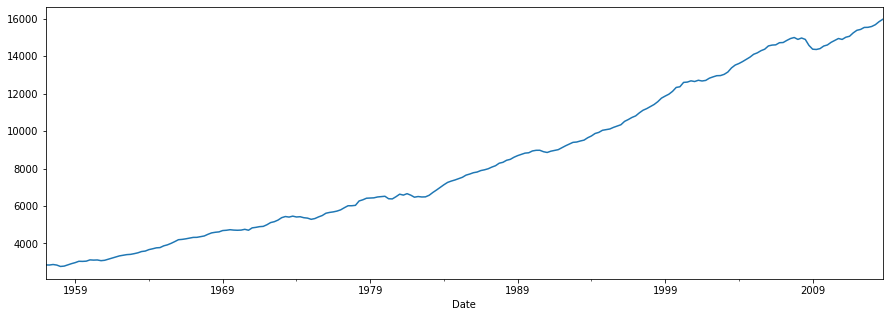

In [ ]:
# GDP
df['GDPC96'].plot(figsize=(15, 5));

In [ ]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()

In [ ]:
df['TSpread'] = df['GS10'] - df['TB3MS']

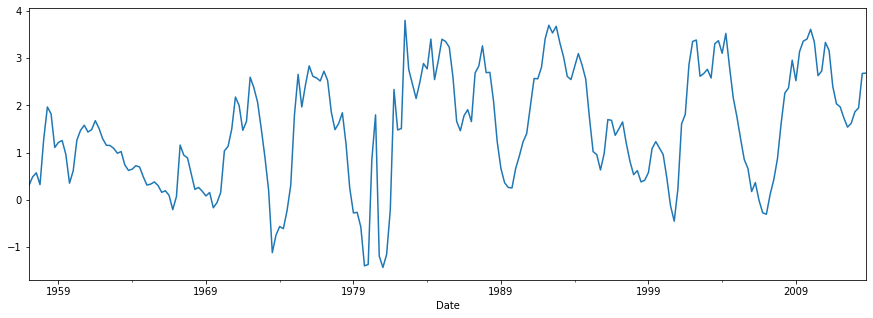

In [ ]:
df['TSpread'].plot(figsize=(15, 5));

In [ ]:
cols = ['GDPGrowth', 'TSpread']

In [ ]:
df1 = df.iloc[1:][cols].copy()

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html
# The Null hypothesis for grangercausalitytests is that the time series in the
# second column, x2, does NOT Granger cause the time series in the first column,
# x1. Grange causality means that past values of x2 have a statistically
# significant effect on the current value of x1, taking past values of x1 into
# account as regressors.

In [ ]:
granger_result = grangercausalitytests(df1, maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=6.2612  , p=0.0123  , df=1
likelihood ratio test: chi2=6.1761  , p=0.0129  , df=1
parameter F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=10.0555 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8373  , p=0.0073  , df=2
parameter F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=10.6710 , p=0.0136  , df=3
likelihood ratio test: chi2=10.4246 , p=0.0153  , df=3
parameter F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8964  , p=0.0230  

In [ ]:
granger_result = grangercausalitytests(df1[reversed(cols)], maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=12.1485 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8332 , p=0.0006  , df=1
parameter F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=11.0476 , p=0.0040  , df=2
likelihood ratio test: chi2=10.7849 , p=0.0046  , df=2
parameter F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=15.1100 , p=0.0017  , df=3
likelihood ratio test: chi2=14.6221 , p=0.0022  , df=3
parameter F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1513  , p=0.0152  